In [1]:
# !/usr/bin/env python
# -*- coding:utf-8 -*-
# author: zhanghongyuan2017@email.szu.edu.cn

import os
import tqdm
import torch
import argparse
import numpy as np
import pandas as pd
from skimage import transform
from skimage import io as sk_io

import warnings
warnings.filterwarnings('ignore')


from utils.model import load_model
from utils.cldetection_utils import check_and_make_dir, calculate_prediction_metrics, visualize_prediction_landmarks

import sys
sys.path.insert(1, '/rds/user/hpcpin1/hpc-work/SegProject')
from utils.dataLoader import LandmarksDataset_NoNorm, ToTensorCL, Rescale
from torchvision import transforms
from utils.losses import load_loss


In [2]:
# data parameters | 数据文件路径
#parser.add_argument('--test_csv_path', type=str)
test_path="/rds/user/hpcpin1/hpc-work/SegProject/Datasets/Cytomine/Cephalo/Train"

# model load dir path | 存放模型的文件夹路径
#parser.add_argument('--load_weight_path', type=str)
load_weight_path="/rds/user/hpcpin1/hpc-work/CL-Detection2023/model_noaug_nonorm__L1_18091358/checkpoint_epoch_390.pt"
# model hyper-parameters: image_width and image_height
#parser.add_argument('--image_width', type=int, default=512)
#parser.add_argument('--image_height', type=int, default=512)
image_width=512

# model test hyper-parameters
#parser.add_argument('--cuda_id', type=int, default=0)
cuda_id=0
#parser.add_argument('--model_name', type=str, default='UNet')
model_name="UNet"
# result & save

#parser.add_argument('--save_image', type=bool, default=True)
save_image=False
#parser.add_argument('--save_image_dir', type=str, default='./visualize/')
save_image_dir='./visualize/'

In [3]:
img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'landmarks')
test_dataset = LandmarksDataset_NoNorm(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(image_width),
                                             ToTensorCL()])
                                 )

In [4]:
# GPU device
gpu_id = cuda_id
os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(gpu_id)
device = torch.device('cuda:{}'.format(gpu_id) if torch.cuda.is_available() else 'cpu')

# load model
model = load_model(model_name)
model.load_state_dict(torch.load(load_weight_path, map_location=device))
model = model.to(device)

# load test.csv
#df = pd.read_csv(config.test_csv_path)

# test result dict
test_result_dict = {}
# test mode
with torch.no_grad():
    model.eval()
    # test all images
    #for index, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    for idx in range(0, len(test_dataset.images)): 
        print(idx, "/", len(test_dataset.images))
        sample = test_dataset[idx]
        image, heatmap_gt, landmarks_gt = sample #['image'], sample['landmarks']
        scale=1
        #image_file_path, scale = str(df.iloc[index, 0]), 1#float(df.iloc[index, 1])
        #landmarks = df.iloc[index, 2:].values.astype('float')
        #landmarks = landmarks.reshape(-1, 2)

        # load image array
        #image = sk_io.imread(image_file_path)
        h, w = image.shape[:2]
        #new_h, new_w = config.image_height, config.image_width

        # preprocessing image for model input
        #image = transform.resize(image, (new_h, new_w), mode='constant', preserve_range=False)
        #transpose_image = np.transpose(image, (2, 0, 1))
        torch_image = torch.from_numpy(image[np.newaxis, :, :, :]).float().to(device)

        # predict heatmap
        heatmap = model(torch_image)
    

        # transfer to landmarks
        heatmap = np.squeeze(heatmap.cpu().numpy())
        predict_landmarks = []
        for i in range(np.shape(heatmap)[0]):
            landmark_heatmap = heatmap[i, :, :]
            yy, xx = np.where(landmark_heatmap == np.max(landmark_heatmap))
            # there may be multiple maximum positions, and a simple average is performed as the final result
            x0, y0 = np.mean(xx), np.mean(yy)
            # zoom to original image size
            x0, y0 = x0 * w / image_width, y0 * h / image_width
            # append to predict landmarks
            predict_landmarks.append([x0, y0])

        test_result_dict[idx] = {'scale': scale,
                                                'gt': np.asarray(landmarks_gt),
                                                'predict': np.asarray(predict_landmarks), 'image': image}

print(test_result_dict)
# calculate prediction metrics
calculate_prediction_metrics(test_result_dict)

# visualize prediction landmarks
if save_image:
    check_and_make_dir(save_image_dir)
    visualize_prediction_landmarks(test_result_dict, save_image_dir)


0 / 40
1 / 40
2 / 40
3 / 40
4 / 40
5 / 40
6 / 40
7 / 40
8 / 40
9 / 40
10 / 40
11 / 40
12 / 40
13 / 40
14 / 40
15 / 40
16 / 40
17 / 40
18 / 40
19 / 40
20 / 40
21 / 40
22 / 40
23 / 40
24 / 40
25 / 40
26 / 40
27 / 40
28 / 40
29 / 40
30 / 40
31 / 40
32 / 40
33 / 40
34 / 40
35 / 40
36 / 40
37 / 40
38 / 40
39 / 40
{0: {'scale': 1, 'gt': array([[175.69405685, 285.86666667],
       [379.96485788, 334.72      ],
       [249.78191214, 321.28      ],
       [365.67648579, 492.8       ],
       [400.60361757, 345.6       ],
       [415.15658915, 429.44      ],
       [420.18397933, 373.97333333],
       [383.66925065, 397.65333333],
       [386.31524548, 398.93333333],
       [183.63204134, 385.06666667],
       [345.30232558, 480.42666667],
       [334.18914729, 484.69333333],
       [352.71111111, 469.33333333],
       [366.73488372, 430.72      ],
       [363.82428941, 352.85333333],
       [159.81808786, 261.97333333],
       [341.06873385, 272.85333333],
       [389.75503876, 219.52      ],
 

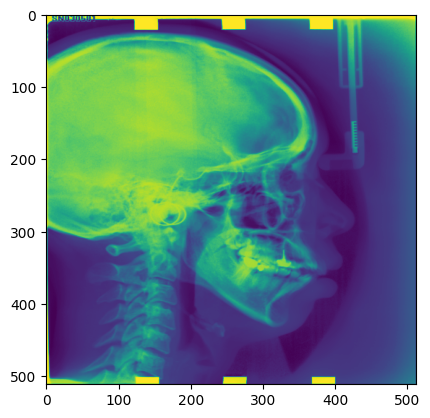

In [5]:
import matplotlib.pyplot as plt
index=2
image=test_result_dict[index]['image']

fig, ax = plt.subplots()
ax.imshow(image[0])



[[183.89664083 276.05333333]
 [363.29509044 301.44      ]
 [256.66149871 298.45333333]
 [347.68372093 436.69333333]
 [396.10542636 311.04      ]
 [398.75142119 388.05333333]
 [410.92299742 340.69333333]
 [374.9374677  353.70666667]
 [368.05788114 362.66666667]
 [193.95142119 345.6       ]
 [329.16175711 430.50666667]
 [316.99018088 434.13333333]
 [335.77674419 421.12      ]
 [342.39173127 386.56      ]
 [379.96485788 334.29333333]
 [157.43669251 258.56      ]
 [331.27855297 255.14666667]
 [364.35348837 204.8       ]
 [202.94780362 221.86666667]]
[[3.25925926e+00 2.53182870e-03]
 [3.56250000e+00 2.56347656e-03]
 [3.66666667e+00 1.30208333e-03]
 [3.00000000e+00 1.95312500e-03]
 [3.72727273e+00 1.77556818e-03]
 [3.64285714e+00 2.37165179e-03]
 [3.64516129e+00 2.39415323e-03]
 [4.00000000e+00 0.00000000e+00]
 [5.11000000e+02 9.98046875e-01]
 [3.55000000e+00 2.63671875e-03]
 [3.92857143e+00 2.23214286e-03]
 [3.00000000e+00 0.00000000e+00]
 [5.11000000e+02 9.98046875e-01]
 [3.62500000e+00 1.

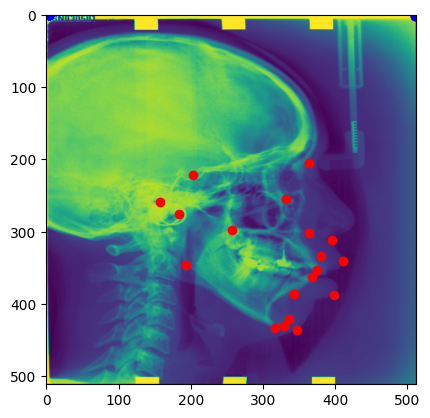

In [6]:
landmarks_pred=test_result_dict[index]['predict']
landmarks_gt=test_result_dict[index]['gt']
print(landmarks_gt)
print(landmarks_pred)
for landmarks in landmarks_gt:
    [x, y] = landmarks
    ax.plot(x,y,'ro') 

for landmarks in landmarks_pred:
    [x, y] = landmarks
    ax.plot(x,y,'bo') 

fig



In [7]:
# !/usr/bin/env python
# -*- coding:utf-8 -*-
# author: zhanghongyuan2017@email.szu.edu.cn

import os
import tqdm
import torch
import argparse
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings('ignore')

#from utils.tranforms import Rescale, RandomHorizontalFlip, ToTensor
#from utils.dataset import CephXrayDataset
from utils.model import load_model
from utils.losses import load_loss


from utils.cldetection_utils import check_and_make_dir

import sys
print("current directory :", os.getcwd())
sys.path.insert(1, '/rds/user/hpcpin1/hpc-work/SegProject')
print(sys.path)
from utils.dataLoader import LandmarksDataset, ToTensorCL, ToTensorLH, Rescale, RandomScale, AugColor, Rotate

##########VALIDATION CHECK
train_csv_path="/rds/user/hpcpin1/hpc-work/SegProject/Datasets/Cytomine/Cephalo/Train"
valid_csv_path="/rds/user/hpcpin1/hpc-work/SegProject/Datasets/Cytomine/Cephalo/Val"



img_path = os.path.join(train_csv_path, 'Images')
label_path = os.path.join(train_csv_path, 'landmarks')


train_dataset = LandmarksDataset_NoNorm(img_path=img_path,
                                 label_path=label_path,
                                transform = transforms.Compose([
                                             Rescale(512),
                                             ToTensorCL()])
                                 )

img_path = os.path.join(valid_csv_path, 'Images')
label_path = os.path.join(valid_csv_path, 'landmarks')
val_dataset = LandmarksDataset_NoNorm(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(512),
                                             ToTensorCL()])
                                 )



train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 8, num_workers = 2)

# train_loader = DataLoader(train_dataset,
#                           batch_size=config.batch_size,
#                           shuffle=True,
#                           num_workers=config.num_workers)
# valid_loader = DataLoader(valid_dataset,
#                           batch_size=config.batch_size_valid,
#                           shuffle=False,
#                           num_workers=config.num_workers)

# load model
# GPU device
gpu_id = cuda_id
os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(gpu_id)
device = torch.device('cuda:{}'.format(gpu_id) if torch.cuda.is_available() else 'cpu')

# load model
model = load_model(model_name='UNet')
model.load_state_dict(torch.load(load_weight_path, map_location=device))
model = model.to(device)

# optimizer and StepLR scheduler
# optimizer = torch.optim.Adam(model.parameters(),
#                              lr=config.lr,
#                              betas=(config.beta1, config.beta2))
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                             step_size=config.scheduler_step_size,
#                                             gamma=config.scheduler_gamma)

# model loss function
loss_fn = load_loss(loss_name='focalLoss')

# model training preparation
train_losses = []
valid_losses = []
best_loss = 1e10
num_epoch_no_improvement = 0


# start to train and valid


current directory : /rds/user/hpcpin1/hpc-work/CL-Detection2023
['/rds/user/hpcpin1/hpc-work/CL-Detection2023', '/rds/user/hpcpin1/hpc-work/SegProject', '/rds/user/hpcpin1/hpc-work/SegProject', '/home/hpcpin1/.conda/envs/torch2/lib/python310.zip', '/home/hpcpin1/.conda/envs/torch2/lib/python3.10', '/home/hpcpin1/.conda/envs/torch2/lib/python3.10/lib-dynload', '', '/home/hpcpin1/.conda/envs/torch2/lib/python3.10/site-packages']


In [8]:
image, heatmap, landmarks = next(iter(train_loader))   


In [9]:
image.shape

torch.Size([8, 1, 512, 512])

In [10]:
image2, heatmap2 = image.float().to(device), heatmap.float().to(device)

In [11]:
image.shape

torch.Size([8, 1, 512, 512])

In [12]:
with torch.no_grad():
    output = model(image2)

In [13]:
output.shape

torch.Size([8, 19, 512, 512])

In [14]:
loss = loss_fn(output, heatmap2)
print(loss)

tensor(11.7511, device='cuda:0')


In [15]:
loss = loss_fn(output, output)
print(loss)

tensor(10.2763, device='cuda:0')


In [16]:
loss = loss_fn(heatmap2, heatmap2)
print(loss)

tensor(0.1579, device='cuda:0')


In [17]:
loss = loss_fn(heatmap, heatmap)
print(loss)

tensor(0.1579, dtype=torch.float64)


In [18]:
image3, heatmap3, landmarks3 = next(iter(train_loader))  
image3, heatmap3 = image3.float().to(device), heatmap3.float().to(device)
with torch.no_grad():
    output3 = model(image3)
print(loss_fn(heatmap3, heatmap3))
print(loss_fn(output3, output3))
print(loss_fn(heatmap3, output3))
print(loss_fn(heatmap2, heatmap3))


tensor(0.1579, device='cuda:0')
tensor(7.8663, device='cuda:0')
tensor(29.8914, device='cuda:0')
tensor(15.1835, device='cuda:0')


In [19]:
image4, heatmap4, landmarks4 = next(iter(train_loader))  
image4, heatmap4 = image4.float().to(device), heatmap4.float().to(device)
with torch.no_grad():
    output4 = model(image4)
print(loss_fn(heatmap4, heatmap4))
print(loss_fn(output4, output4))
print(loss_fn(heatmap4, output4))
print(loss_fn(heatmap4, heatmap3))

tensor(0.1579, device='cuda:0')
tensor(7.9079, device='cuda:0')
tensor(29.9136, device='cuda:0')
tensor(15.3832, device='cuda:0')


In [20]:
heatmap3.shape

torch.Size([8, 19, 512, 512])

In [21]:
for epoch in range(config.train_max_epoch):
    scheduler.step(epoch)
    model.train()
    for (image, heatmap, landmarks) in tqdm.tqdm(train_loader):
        image, heatmap = image.float().to(device), heatmap.float().to(device)
        output = model(image)
        loss = loss_fn(output, heatmap)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(round(loss.item(), 3))
    print('Train epoch [{:<4d}/{:<4d}], Loss: {:.6f}'.format(epoch + 1, config.train_max_epoch, np.mean(train_losses)))
    writer.add_scalar('Train/Loss', np.mean(train_losses), epoch)

    # save model checkpoint
    if epoch % config.save_model_step == 0:
        torch.save(model.state_dict(), os.path.join(config.save_model_dir, 'checkpoint_epoch_%s.pt' % epoch))
        print("Saving checkpoint model ", os.path.join(config.save_model_dir, 'checkpoint_epoch_%s.pt' % epoch))

    # valid model, save best_checkpoint.pkl
    with torch.no_grad():
        model.eval()
        print("Validating....")
        for (image, heatmap, landmarks) in tqdm.tqdm(valid_loader):
            image, heatmap = image.float().to(device), heatmap.float().to(device)
            output = model(image)
            loss = loss_fn(output, heatmap)
            valid_losses.append(loss.item())
    valid_loss = np.mean(valid_losses)
    print('Validation loss: {:.6f}'.format(valid_loss))
    writer.add_scalar('Validation/Loss', valid_loss, epoch)

    # early stop mechanism
    if valid_loss < best_loss:
        print("Validation loss decreases from {:.6f} to {:.6f}".format(best_loss, valid_loss))
        best_loss = valid_loss
        num_epoch_no_improvement = 0
        torch.save(model.state_dict(), os.path.join(config.save_model_dir, "best_model.pt"))
        print("Saving best model ", os.path.join(config.save_model_dir, "best_model.pt"))
    else:
        print("Validation loss does not decrease from {:.4f}, num_epoch_no_improvement {}".format(best_loss, num_epoch_no_improvement))
        num_epoch_no_improvement += 1
    if num_epoch_no_improvement == config.epoch_patience:
        print("Early Stopping!")
        break
    
    # reset parameters
    train_losses = []
    valid_losses = []

NameError: name 'config' is not defined